# Analysis of opinions on Twitter on hashtag #metoo in 2020-2022

#MeToo is a social movement and awareness campaign against sexual abuse, sexual harassment, and rape culture, in which people publicize their experiences of sexual abuse or sexual harassment.

## Libraries

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import string
import text2emotion as te
from wordcloud import WordCloud
import seaborn as sns
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Scraping tweets
We are downloading English tweets with the hashtag #metoo from January 1, 2020, to December 28, 2022.
We will save the tweets in a CSV file (ID, Text, Author, and Date).

In [2]:
max_tweets = 100
tweets_list = []

for year in range(2020, 2023):
    for month in range(1, 13):
        for day in range(1, 29):
            date_query = f'{year}-{month:02d}-{day:02d}'
            query = f'lang:en #metoo until:{date_query}'
            scraper = sntwitter.TwitterSearchScraper(query)
            
            for i, tweet in enumerate(scraper.get_items()):
                if i >= max_tweets:
                    break
                tweets_list.append(tweet)

csv_file = 'tweets.csv'
fieldnames = ['ID', 'Text', 'Author', 'Date']
with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for tweet in tweets_list:
        writer.writerow({'ID': tweet.id,
                         'Text': tweet.content,
                         'Author': tweet.user.username,
                         'Date': tweet.date})


Unavailable user in card on tweet 1219344508862767105
User 28550209 not found in user refs in card on tweet 1219344508862767105
Unavailable user in card on tweet 1230640868660400128
Unavailable user in card on tweet 1230640868660400128
User 13986352 not found in user refs in card on tweet 1230640868660400128
User 13986352 not found in user refs in card on tweet 1230640868660400128
Unavailable user in card on tweet 1231701937088655360
Unavailable user in card on tweet 1231701937088655360
User 76227785 not found in user refs in card on tweet 1231701937088655360
User 76227785 not found in user refs in card on tweet 1231701937088655360
Stopping after 20 empty pages
Unavailable user in card on tweet 1291121093156245504
User 4917059115 not found in user refs in card on tweet 1291121093156245504
Unavailable user in card on tweet 1293670199174938624
User 933016351756742656 not found in user refs in card on tweet 1293670199174938624
Unavailable user in card on tweet 1295933565063049216
Unavaila

In [3]:
tweets = pd.read_csv('tweets.csv', parse_dates=['Date'])

## Preprocessing

We will now retrieve the first five tweets with the #metoo hashtag in order to preview and ensure that everything appears correct.

In [4]:
tweets.head(5)

,ID,Text,Author,Date
0,1212161461365231616,@XManTheFuckUpX #metoo please,mark_anderson29,2019-12-31 23:59:47+00:00
1,1212161241721917440,"Poll for #women, would you rather purchase a r...",kalin_kelly,2019-12-31 23:58:55+00:00
2,1212160651424129026,Fireworks and cheers ushered in 2020 around th...,Queen_City_News,2019-12-31 23:56:34+00:00
3,1212158952948916224,Thats abuse. #Metoo,PatriotBroker,2019-12-31 23:49:49+00:00
4,1212157998430330880,#MeToo. Happy New year @yohgirlsamantha,AStarInTheDark,2019-12-31 23:46:02+00:00


There is 98137 tweets scrapped in our dataset.

In [5]:
tweets.shape[0]

98137

Code below is used to convert the text of each tweet to lowercase.

In [6]:
tweets['Text'] = tweets['Text'].apply(lambda x: x.lower())

As we can see it converted text successfully.

In [7]:
tweets.head(5)

,ID,Text,Author,Date
0,1212161461365231616,@xmanthefuckupx #metoo please,mark_anderson29,2019-12-31 23:59:47+00:00
1,1212161241721917440,"poll for #women, would you rather purchase a r...",kalin_kelly,2019-12-31 23:58:55+00:00
2,1212160651424129026,fireworks and cheers ushered in 2020 around th...,Queen_City_News,2019-12-31 23:56:34+00:00
3,1212158952948916224,thats abuse. #metoo,PatriotBroker,2019-12-31 23:49:49+00:00
4,1212157998430330880,#metoo. happy new year @yohgirlsamantha,AStarInTheDark,2019-12-31 23:46:02+00:00


The 'tweets' dataframe is preprocessed to remove duplicates, remove HTML tags using BeautifulSoup, remove retweet indicators ('RT @username'), remove URLs, remove Twitter handles (@username), remove newline characters, remove extra whitespace, remove punctuation, and keep only alphabetical characters and is then cleaned from any rows with missing values (NaN), and the final count of remaining tweets is returned.

In [8]:
tweets=tweets.drop_duplicates(subset=['Text'],keep='last').copy()
tweets['Text'] = tweets['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
tweets = tweets[~tweets['Text'].str.contains('RT @[\w_]+:')]
tweets = tweets[~tweets['Text'].str.contains('http://')]
tweets = tweets[~tweets['Text'].str.contains('https://')]
tweets['Text'] = tweets['Text'].str.replace('@[A-Za-z0-9_]+(:)?', '', regex=True)
tweets['Text'] = tweets['Text'].str.replace(r'\n', '', regex=True)
tweets['Text'] = tweets['Text'].str.replace(r'\s+', ' ', regex=True)
translator = str.maketrans('', '', string.punctuation)
tweets['Text'] = tweets['Text'].apply(lambda x: x.translate(translator))
tweets['Text'] = tweets['Text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
tweets = tweets.dropna()
tweets.shape[0]

/var/folders/3s/yv11sf053fj15v7y1m52g2780000gn/T/ipykernel_43864/120631051.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweets['Text'] = tweets['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
/var/folders/3s/yv11sf053fj15v7y1m52g2780000gn/T/ipykernel_43864/120631051.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  tweets['Text'] = tweets['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


58162

In [9]:
tweets.head(10)

,ID,Text,Author,Date
0,1212161461365231616,metoo please,mark_anderson29,2019-12-31 23:59:47+00:00
1,1212161241721917440,poll for women would you rather purchase a rin...,kalin_kelly,2019-12-31 23:58:55+00:00
3,1212158952948916224,thats abuse metoo,PatriotBroker,2019-12-31 23:49:49+00:00
4,1212157998430330880,metoo happy new year,AStarInTheDark,2019-12-31 23:46:02+00:00
5,1212156656160837635,hope its free from metoo campaign in true sense,pristrivedi,2019-12-31 23:40:42+00:00
10,1212153861638643718,before metoo there was rosaparks and recytaylor,ShinoJin86,2019-12-31 23:29:36+00:00
14,1212150232990928897,terry fator was disappointingjokes making lig...,j_d_cummings,2019-12-31 23:15:10+00:00
15,1212150105383538693,it is a little odd to say metoo instead of sex...,starwolf_oakley,2019-12-31 23:14:40+00:00
16,1212149870062112769,should already be obvious but since yall dont...,genderUFOria,2019-12-31 23:13:44+00:00
17,1212149862721966081,newyearthings that inspired me this past d...,Dktr_Sus,2019-12-31 23:13:42+00:00


In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aleksandramordzon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The 'stop_words' variable is initialized with a list of common English stopwords obtained from the NLTK library. Additional custom stopwords, such as '#', and 'metoo', are also added to the list.
The 'lemmatizer' variable is initialized with an instance of the WordNetLemmatizer class from NLTK, which is used for lemmatization - reducing words to their base or dictionary form.

Example:

Word Before Lemmatization: cats 

Word After Lemmatization: cat 

In [11]:
stop_words = stopwords.words('english')
stop_words.extend(['#', 'metoo'])
lemmatizer = WordNetLemmatizer()

tweets_df_lemmatized = tweets.copy()


In [12]:
def tokenize_and_lemmatize(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

tweets_df_lemmatized['Text'] = tweets_df_lemmatized['Text'].apply(lambda x: tokenize_and_lemmatize(x))


The provided code initializes a sentiment analyzer and computes the compound sentiment score for each tweet's text, storing the scores in a new 'sentiment' column in the dataframe.

In [13]:
analyzer = SentimentIntensityAnalyzer()
tweets_df_lemmatized['sentiment'] = tweets_df_lemmatized['Text'].apply(lambda x: analyzer.polarity_scores(' '.join(x))['compound'])

The minimum sentiment represents the most negative sentiment score, while the maximum sentiment represents the most positive sentiment score among the tweets in the 'tweets_df_lemmatized' dataframe.

In [14]:
max_sentiment = tweets_df_lemmatized['sentiment'].max()
min_sentiment = tweets_df_lemmatized['sentiment'].min()
print("max: ", max_sentiment, "min: ", min_sentiment)

max:  0.9776 min:  -0.9933


The provided code assigns the labels 'positive', 'negative', or 'neutral' to the 'opinion' column of the 'tweets_df_lemmatized' dataframe based on the sentiment score from the 'sentiment' column.

In [15]:
tweets_df_lemmatized['opinion']=tweets_df_lemmatized['sentiment'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'neutral')

There is 26930 negative, 20780 positive and 10452 neutral opinions.

In [16]:
value_counts = tweets_df_lemmatized['opinion'].value_counts()
value_counts

negative    26930
positive    20780
neutral     10452
Name: opinion, dtype: int64

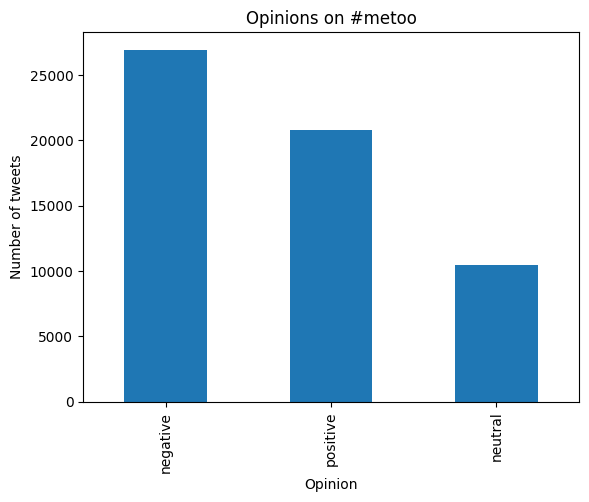

In [17]:
value_counts.plot.bar()

plt.title('Opinions on #metoo')
plt.xlabel('Opinion')
plt.ylabel('Number of tweets')

plt.show()

In [18]:
most_positive = tweets_df_lemmatized[tweets_df_lemmatized['sentiment'] == max_sentiment]['Text'].values[0]
most_negative = tweets_df_lemmatized[tweets_df_lemmatized['sentiment'] == min_sentiment]['Text'].values[0]

print("Most positive tweet: ", most_positive)
print("Most negative tweet: ", most_negative)

Most positive tweet:  ['thank', 'sharing', 'life', 'sophia', 'beautiful', 'deep', 'thank', 'sending', 'love', 'compassion', 'always', 'sharing', 'sweetheart', 'u', 'childloss']
Most negative tweet:  ['horrendous', 'egregious', 'unconscionable', 'horrific', 'terrifying', 'outrageous', 'damaging', 'criminal', 'foul', 'disgusting', 'bad', 'conduct', 'devastating', 'vile', 'nasty', 'inexcusable', 'shocking', 'heartbreaking', 'inhumane', 'accountabilityjusticenow']


In [19]:
most_positive_date = tweets_df_lemmatized[tweets_df_lemmatized['sentiment'] == max_sentiment]['Date'].values[0]
most_negative_date = tweets_df_lemmatized[tweets_df_lemmatized['sentiment'] == min_sentiment]['Date'].values[0]

print("Most positive tweet date: ", most_positive_date)
print("Most negative tweet date: ", most_negative_date)

Most positive tweet date:  2020-01-07T22:42:17.000000000
Most negative tweet date:  2021-10-24T23:26:09.000000000


### Most popular words

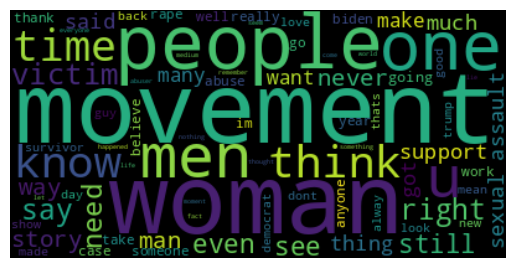

In [20]:
words = ' '.join(tweets_df_lemmatized['Text'].apply(' '.join))
wordcloud = WordCloud().generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


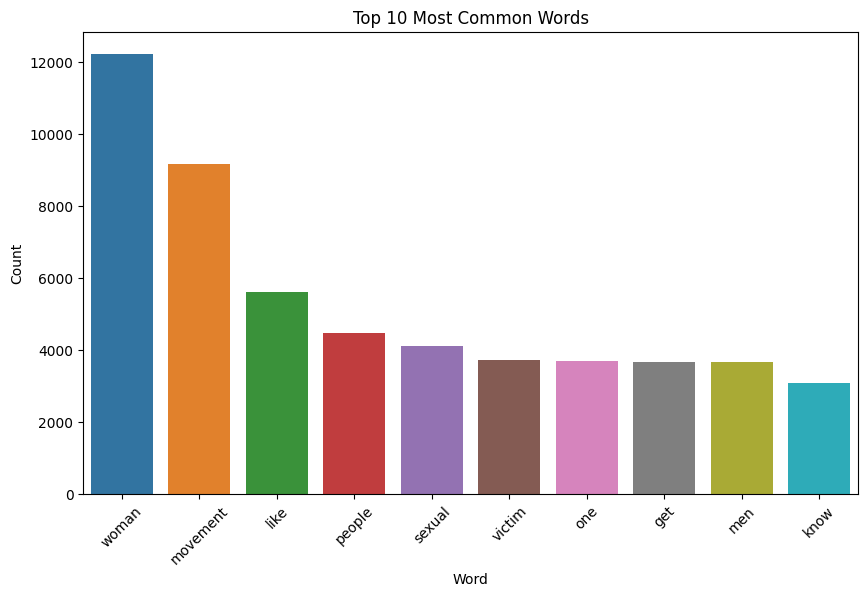

In [21]:
word_counts = tweets_df_lemmatized['Text'].apply(' '.join).str.split().explode().value_counts()
most_common_words = word_counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=most_common_words.index, y=most_common_words.values)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

### Emotions

The code creates a new dataframe called 'emotion_tweets_df' as a copy of the 'tweets_df_lemmatized' dataframe and assigns emotion labels to the 'emotion' column based on the text content of each tweet using the TextEmotion library's get_emotion() function.

It includes such emotions as **Angry**, **Fear**, **Happy**, **Sad**, **Surprise**

In [22]:
emotion_tweets_df = tweets_df_lemmatized.copy()
emotion_tweets_df['emotion'] = emotion_tweets_df['Text'].apply(lambda x: te.get_emotion(' '.join(x)))


In [23]:
emotion_tweets_df.head(5)

,ID,Text,Author,Date,sentiment,opinion,emotion
0,1212161461365231616,[please],mark_anderson29,2019-12-31 23:59:47+00:00,0.3182,positive,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
1,1212161241721917440,"[poll, woman, would, rather, purchase, ring, i...",kalin_kelly,2019-12-31 23:58:55+00:00,0.6249,positive,"{'Happy': 0.11, 'Angry': 0.11, 'Surprise': 0.0..."
3,1212158952948916224,"[thats, abuse]",PatriotBroker,2019-12-31 23:49:49+00:00,-0.6369,negative,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
4,1212157998430330880,"[happy, new, year]",AStarInTheDark,2019-12-31 23:46:02+00:00,0.5719,positive,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
5,1212156656160837635,"[hope, free, campaign, true, sense]",pristrivedi,2019-12-31 23:40:42+00:00,0.8402,positive,"{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.0, ..."


We save it to csv file.

In [24]:
emotion_tweets_df.to_csv('emotions-tweets.csv', index=False)

The provided code adds columns corresponding to the emotions "Angry", "Fear", "Happy", "Sad", and "Surprise" to the 'emotion_tweets_df' dataframe, with each column containing the presence or absence of that specific emotion based on the values in the 'emotion' column.

In [25]:
emotions=['Angry', 'Fear', 'Happy', 'Sad', 'Surprise']
for i in emotions:
    emotion_tweets_df[i]=emotion_tweets_df["emotion"].apply(lambda x: x[i])

In [26]:
emotion_tweets_df.head(5)

,ID,Text,Author,Date,sentiment,opinion,emotion,Angry,Fear,Happy,Sad,Surprise
0,1212161461365231616,[please],mark_anderson29,2019-12-31 23:59:47+00:00,0.3182,positive,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':...",0.00,0.00,0.00,0.00,0.0
1,1212161241721917440,"[poll, woman, would, rather, purchase, ring, i...",kalin_kelly,2019-12-31 23:58:55+00:00,0.6249,positive,"{'Happy': 0.11, 'Angry': 0.11, 'Surprise': 0.0...",0.11,0.67,0.11,0.11,0.0
3,1212158952948916224,"[thats, abuse]",PatriotBroker,2019-12-31 23:49:49+00:00,-0.6369,negative,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':...",0.00,0.00,0.00,0.00,0.0
4,1212157998430330880,"[happy, new, year]",AStarInTheDark,2019-12-31 23:46:02+00:00,0.5719,positive,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.00,1.00,0.00,0.0
5,1212156656160837635,"[hope, free, campaign, true, sense]",pristrivedi,2019-12-31 23:40:42+00:00,0.8402,positive,"{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.50,0.50,0.00,0.0


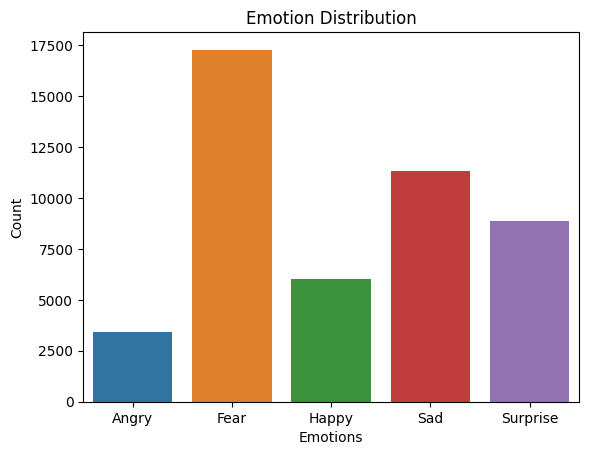

In [27]:
emotions=['Angry', 'Fear', 'Happy', 'Sad', 'Surprise']
data=[emotion_tweets_df.Angry.sum(),emotion_tweets_df.Fear.sum(),emotion_tweets_df.Happy.sum(),emotion_tweets_df.Sad.sum(),emotion_tweets_df.Surprise.sum()]
sns.barplot(x=emotions, y=data)

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Distribution')

plt.show()

As we can observe, the most frequently experienced emotion is fear, followed by sadness. The least common emotion is anger.

In [28]:
emotion_tweets_df['Date'] = pd.to_datetime(emotion_tweets_df['Date']).dt.date

The provided code calculates the daily average sentiment by grouping the 'emotion_tweets_df' dataframe by the 'Date' column and calculating the mean of the 'sentiment' column for each day.

In [29]:
daily_sentiment_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['sentiment'].mean()

# Overall analysis

### Sentiment over time

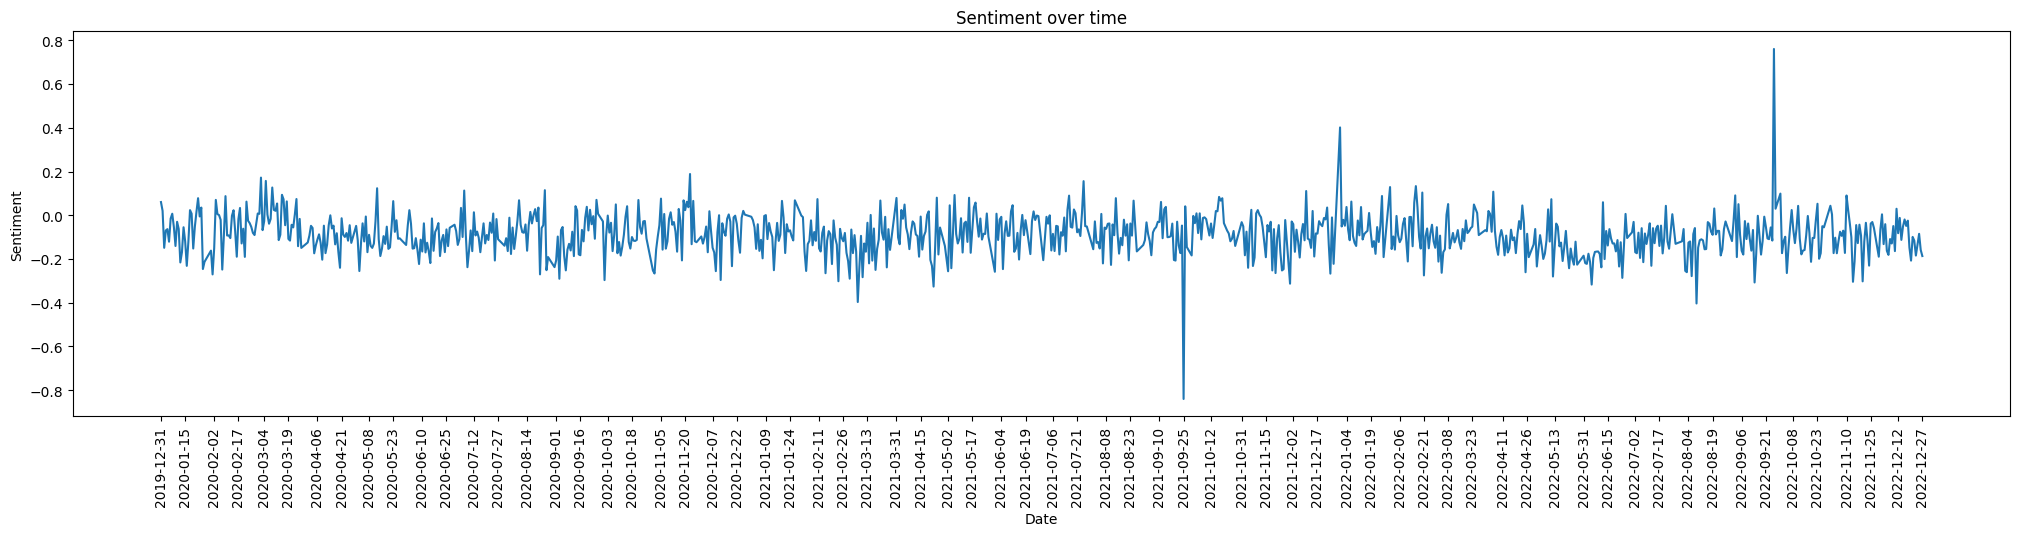

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(daily_sentiment_df.index, daily_sentiment_df.values)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment over time')
plt.xticks(daily_sentiment_df.index[::15], rotation=90)


plt.show()

On the chart, we can observe that the sentiment values fluctuate within the range of -0.2 to 0.2. Around September 25, 2021, there was a sharp increase in negative tweets, while in September 2022, the average positive emotions reached the highest level.

The decline in moods may be associated with the fact that during this time, prosecutors began their closing arguments in the R. Kelly trial. R. Kelly, an American singer and songwriter, has faced numerous legal charges, including allegations of sexual abuse, exploitation of minors, and other related offenses.

In [31]:
daily_happy_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['Happy'].mean()
daily_angry_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['Angry'].mean()
daily_sad_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['Sad'].mean()
daily_fear_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['Fear'].mean()
daily_surprise_df = emotion_tweets_df.groupby(emotion_tweets_df['Date'])['Surprise'].mean()


In [32]:
print(daily_happy_df.head())

Date
2019-12-31    0.174815
2020-01-01    0.092373
2020-01-02    0.100656
2020-01-03    0.100667
2020-01-04    0.123400
Name: Happy, dtype: float64


### Emotions over time

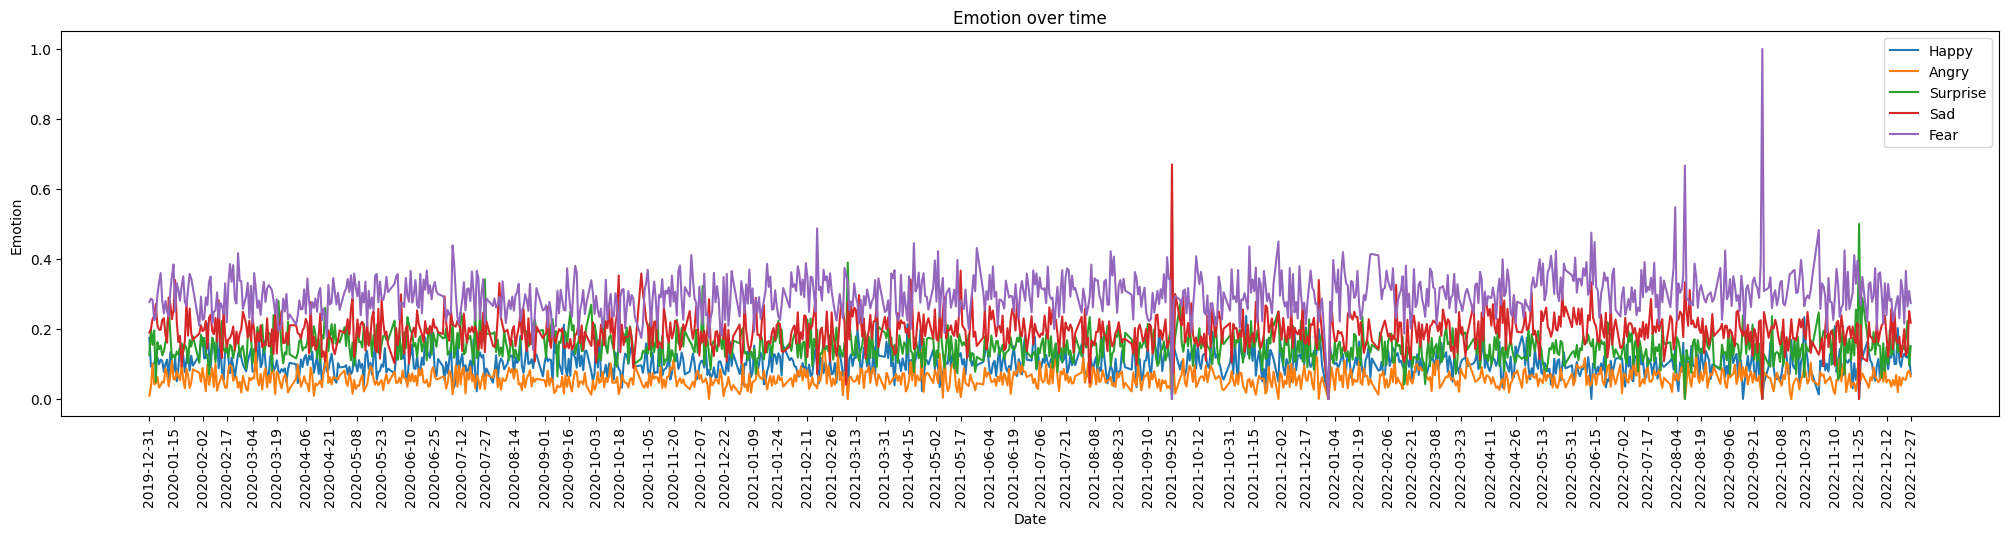

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(daily_happy_df.index, daily_happy_df, label='Happy')
plt.plot(daily_angry_df.index, daily_angry_df, label='Angry')
plt.plot(daily_surprise_df.index, daily_surprise_df, label='Surprise')
plt.plot(daily_sad_df.index, daily_sad_df, label='Sad')
plt.plot(daily_fear_df.index, daily_fear_df, label='Fear')
plt.xlabel('Date')
plt.ylabel('Emotion')
plt.title('Emotion over time')
plt.xticks(daily_happy_df.index[::15], rotation=90)
plt.legend()
plt.show()


We can observe on the chart that the most prevalent emotion is fear, while anger is the least expressed. There was a significant increase in sadness on September 25, 2021, which could be related to the R. Kelly trial or Sophia Huang Xueqin – China’s #MeToo Activist Who Went Missing. In September 2022, there was a sharp rise in fear. It may be correlated with actress Tanushree Dutta claimimg that someone tried to poison her after her #MeToo revelation.

# Summary

The majority of tweets with the hashtag #MeToo from 2020 to 2022 have a negative sentiment, with fear and sadness prevailing. Over the course of two years, the overall sentiments did not change significantly. There were a few years when certain emotions experienced a sudden increase, but they returned to their original state.